# Project title: Binary Classification


#### In this project we will be using the given videos stored in a tensor format that holds 18 different categories of objects inside these videos and also extra information such as the bounding boxes of the objects, coordinates, segmentation masks, depth masks,..etc.

* first we will load the data using the method provided by the professor in the given notebook("project.ipynb").

* then we will divide the videos into frames to facilitate dealing with the data.

* then we will extract the categories of the objects for each frame which will be our labels for the classification task.
* we will explore the data and visualize a sample of it to help us decide which class we will use to apply our Binary Classification task.


* after selecting the class we will use,  we will modify the labels to be 1 for the selected class and 0 for the rest of the classes.


* finally we will apply some preprocessing techniques to prepare the data for the classification task.



## import library

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.exposure import equalize_hist
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## load data

In [2]:
# in this section we will load the data from the tensorflow dataset
tfds.disable_progress_bar()
PROJECT_ROOT_DIR ="/content/drive/MyDrive/my info/img/cvproject"
print(PROJECT_ROOT_DIR)

data_path = os.path.join(PROJECT_ROOT_DIR, 'tensorflow_data')
data_path = os.path.join(data_path, 'tensorflow_data')
os.makedirs(data_path, exist_ok = True)
print("Using directory: ", data_path)

flow_data_set_linear   = tfds.load('elg7186_projectdata/linear_movement_rotate', data_dir=data_path)
flow_data_set_rotation = tfds.load('elg7186_projectdata/rotation_rotate', data_dir=data_path)
flow_data_set_fixed    = tfds.load('elg7186_projectdata/fixed_random_rotate', data_dir=data_path)


/content/drive/MyDrive/my info/img/cvproject
Using directory:  /content/drive/MyDrive/my info/img/cvproject/tensorflow_data/tensorflow_data


In [3]:
# this function is used to make a dataframe from the tensorflow dataset by iterating through the videos then take the frames
# for each video and append them to the dataframe with the corresponding categories

def make_df(data_set):
    df = pd.DataFrame()
    iter_data = iter(data_set['train'])
    for i in range(len(data_set['train'])):
        train_data = next(iter_data)
        for j in range(len(train_data['video'])):
            df = df.append({'img':np.array(train_data['video'][j, :, :, :])
            ,'y': train_data['instances']['category'].numpy()}, ignore_index=True)
    return df

#create dataframes for each dataset and then concatenate them into one dataframe, in these dataframes we have
# 30 videos with 24 frames each, so we have 720 frames in total for each dataset, we have 3 datasets so we have 2160 frames in total

df_linear = make_df(flow_data_set_linear)  #720 frames
df_fixed = make_df(flow_data_set_fixed)    #720 frames
df_rot = make_df(flow_data_set_rotation)   #720 frames
df = pd.concat([df_linear, df_fixed, df_rot], ignore_index=True)  #2160 frames
df.sample(5)

<ipython-input-3-15dfed1148a6>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'img':np.array(train_data['video'][j, :, :, :])
<ipython-input-3-15dfed1148a6>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'img':np.array(train_data['video'][j, :, :, :])
<ipython-input-3-15dfed1148a6>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'img':np.array(train_data['video'][j, :, :, :])
<ipython-input-3-15dfed1148a6>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'img':np.array(train_data['video'][j, :, :, :])
<ipython-input-3-15dfed1148a6>:10: FutureWarning: The frame.appe

,img,y
1327,"[[[55, 70, 44], [42, 53, 38], [37, 44, 33], [4...","[6, 14, 3, 14, 0, 6, 9]"
2112,"[[[170, 157, 167], [172, 157, 161], [175, 159,...","[16, 13, 13, 13, 14, 13, 6]"
232,"[[[201, 186, 153], [199, 184, 163], [198, 182,...","[6, 14, 14]"
2074,"[[[196, 169, 107], [195, 168, 105], [195, 168,...",[6]
1645,"[[[153, 145, 44], [158, 149, 43], [151, 142, 4...","[16, 6, 6, 6, 1, 13, 16]"


In [4]:
# datasets shapes
print(df_linear.shape)
print(df_fixed.shape)
print(df_rot.shape)

(720, 2)
(720, 2)
(720, 2)


## visualizing some examples

In [5]:
df_rot.sample(5)

,img,y
399,"[[[199, 170, 112], [197, 166, 108], [194, 161,...","[13, 6, 14]"
618,"[[[61, 56, 38], [60, 55, 37], [62, 57, 39], [6...","[13, 0, 14]"
495,"[[[136, 149, 166], [136, 147, 163], [130, 140,...","[6, 14, 3, 16, 6, 14]"
112,"[[[181, 167, 148], [177, 165, 146], [174, 162,...","[16, 14, 13]"
695,"[[[74, 101, 78], [100, 119, 99], [97, 121, 110...","[16, 13, 13, 13, 14, 13, 6]"


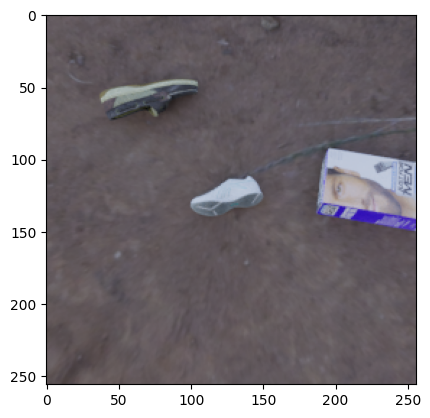

In [6]:
plt.imshow(np.array(df_rot['img'][426]))

## sample of data

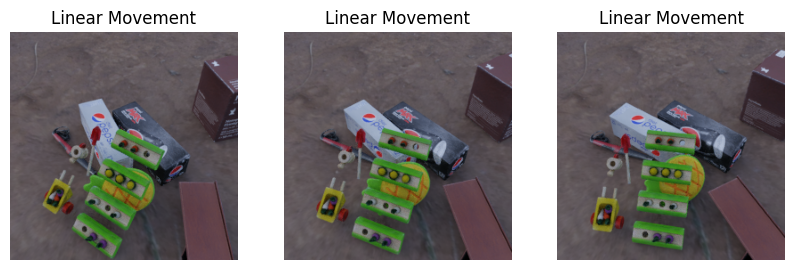

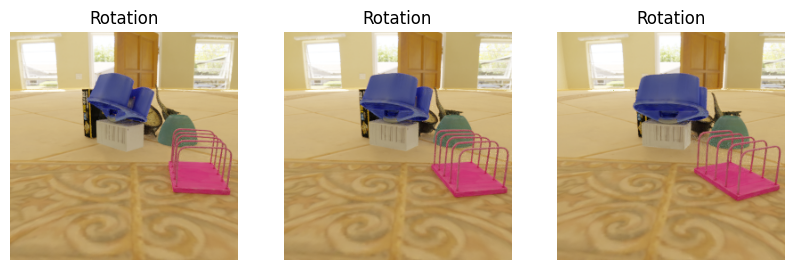

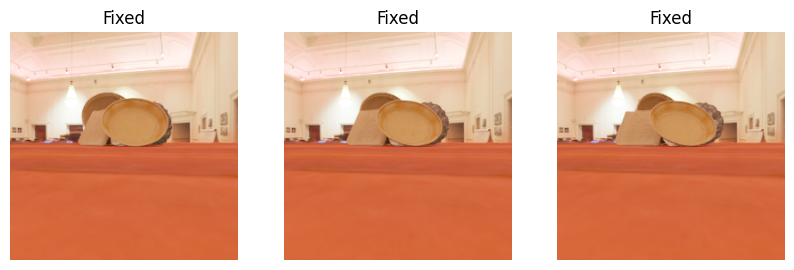

In [7]:
# in this section we will visualize the data by plotting some images from each dataset to see the difference between them

#linear move dataset
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(df_linear['img'][0])
ax[0].set_title('Linear Movement')
ax[0].axis('off')
ax[1].imshow(df_linear['img'][1])
ax[1].set_title('Linear Movement')
ax[1].axis('off')
ax[2].imshow(df_linear['img'][2])
ax[2].set_title('Linear Movement')
ax[2].axis('off')
plt.show()

# rotation dataset
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(df_rot['img'][0])
ax[0].set_title('Rotation')
ax[0].axis('off')
ax[1].imshow(df_rot['img'][1])
ax[1].set_title('Rotation')
ax[1].axis('off')
ax[2].imshow(df_rot['img'][2])
ax[2].set_title('Rotation')
ax[2].axis('off')
plt.show()


#fixed dataset
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(df_fixed['img'][0])
ax[0].set_title('Fixed')
ax[0].axis('off')
ax[1].imshow(df_fixed['img'][1])
ax[1].set_title('Fixed')
ax[1].axis('off')
ax[2].imshow(df_fixed['img'][2])
ax[2].set_title('Fixed')
ax[2].axis('off')
plt.show()

In [8]:
# getting the most frequent class to classify based on it to gurantee data balance
from collections import Counter
Counter([item for sublist in df['y'] for item in sublist]).most_common(1)

[(14, 2208)]

## make a copy from the dataframe to keep the original one away from modification

In [9]:
import copy
df_copy = copy.deepcopy(df)
df_copy['z'] = df_copy['y'].apply(lambda x: 1 if 14 in x else 0)  # 14 is shoe

In [10]:
df_copy.sample(5)

,img,y,z
1738,"[[[113, 111, 94], [111, 108, 92], [160, 151, 1...",[14],1
527,"[[[131, 128, 117], [129, 125, 114], [129, 125,...","[6, 11, 6, 1, 6, 16]",0
590,"[[[197, 214, 229], [197, 214, 229], [197, 214,...",[14],1
2061,"[[[75, 71, 50], [77, 72, 50], [68, 63, 39], [7...","[13, 0, 14]",1
474,"[[[44, 66, 34], [46, 71, 35], [54, 79, 37], [6...",[6],0


## Now we should check for the data balance to avoid any problems that may appear due to data imbalance

Text(0.5, 1.0, 'Histogram of Shoe(1) vs. Non-Shoe(0)')

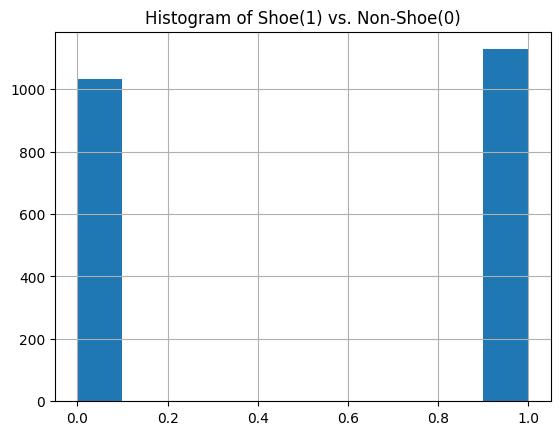

In [14]:
df_copy['z'].hist()
title = 'Histogram of Shoe(1) vs. Non-Shoe(0)'
plt.title(title)

## As we see the chosen class "shoe" (14) is a great choice for our binary classification problem

## Image preprocessing

In [12]:
# This function is used to preprocess the images by resizing them to 128x128,
# then enhancing them using unsharp mask, then denoising them

def preprocess_image(img, desired_size=(128, 128)):
    # Resizing
    img = resize(img, desired_size)

    # Enhancing the image using unsharp mask
    img = unsharp_mask(img)

    # Denoising
    sigma_est = np.mean(estimate_sigma(img, multichannel=True))
    img = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=True, multichannel=True)

    # Histogram Equalization for enhancing contrast
    img = equalize_hist(img)

    # Convert to grayscale
    gray_img = rgb2gray(img)

    # Expand the dimensions to fit the model input shape
    return np.expand_dims(gray_img, axis=-1)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
<ipython-input-12-e4028d57acde>:12: FutureWarning: `multichannel` is a deprecated argument name for `estimate_sigma`. It will be removed in version 1.0. Please use `channel_axis` instead.
  sigma_est = np.mean(estimate_sigma(img, multichannel=True))
<ipython-input-12-e4028d57acde>:13: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=True, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function t

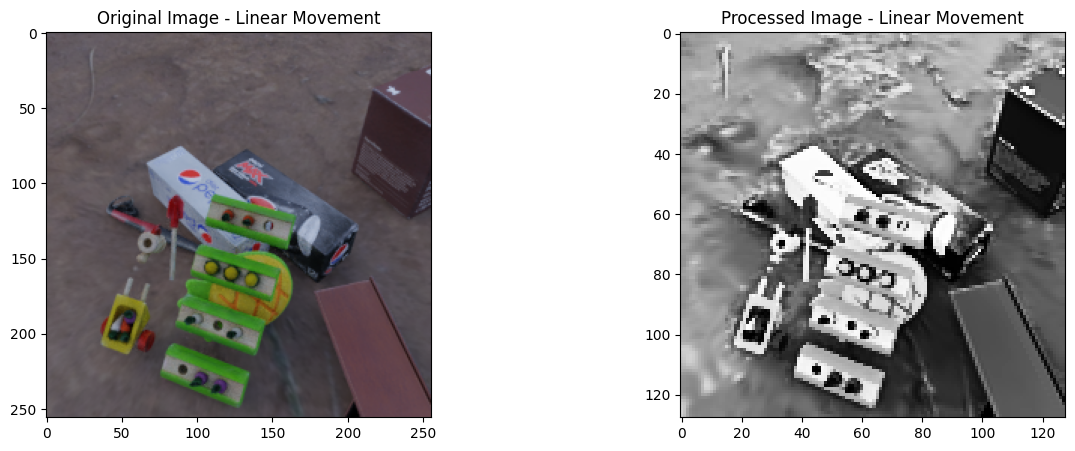

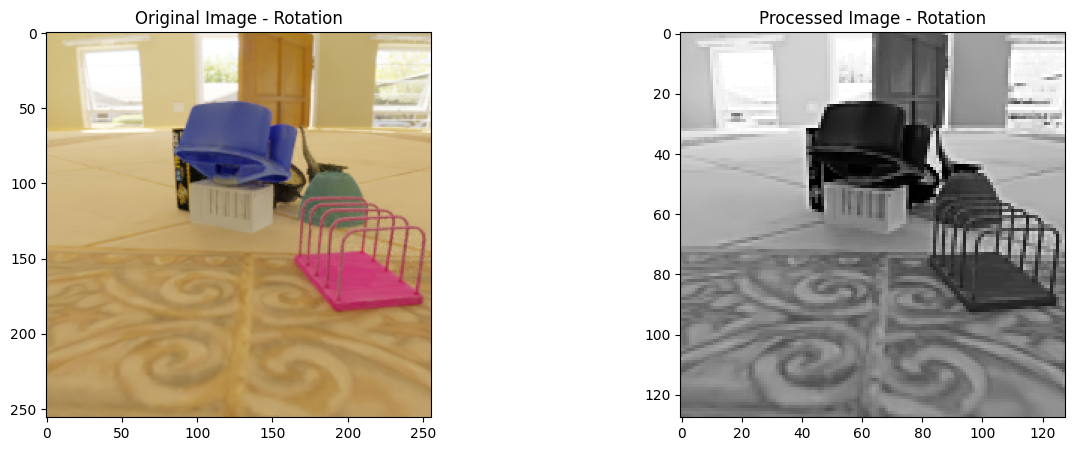

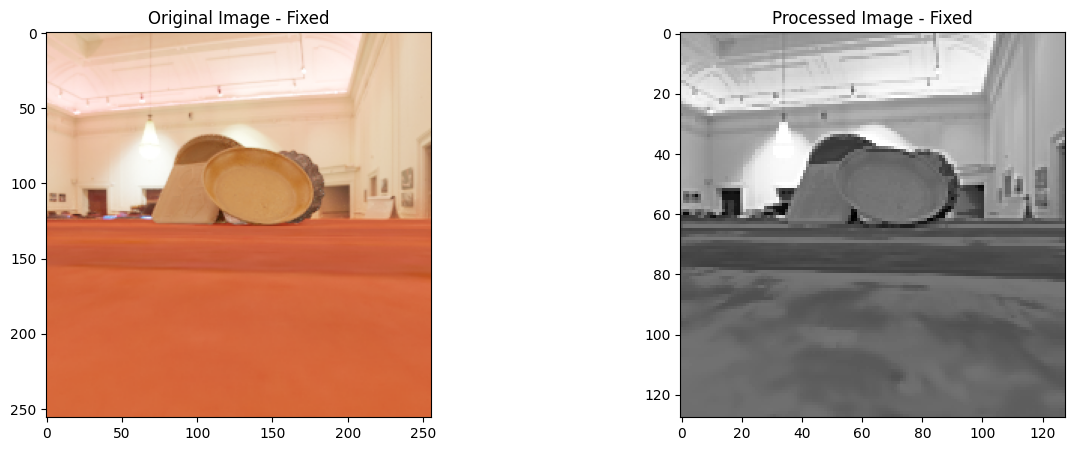

In [13]:
# this function is used to display the images before and after preprocessing
def display_image_processing(df, title):
      img = df['img'][1]
      processed_img = preprocess_image(img)
      fig, ax = plt.subplots(1, 2, figsize=(15, 5))
      ax[0].imshow(img)
      ax[0].set_title(f"Original Image - {title}")
      ax[1].imshow(processed_img.squeeze(), cmap='gray')
      ax[1].set_title(f"Processed Image - {title}")
      plt.show()

# Display for each dataframe
display_image_processing(df_linear, 'Linear Movement')
display_image_processing(df_rot, 'Rotation')
display_image_processing(df_fixed, 'Fixed')

# Now the data is ready for the training step